# Dask dataframes on HDFS

To use Dask dataframes in parallel across an HDFS cluster to read CSV data. We can coordinate these computations with [distributed](http://distributed.dask.org/en/latest/) and dask.dataframe.

As Spark, Dask can work in cluster mode. There is several ways to launch a cluster.

## Local cluster

In [ ]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
cluster

## Remote clusters via SSH

Code below can be used to launch a Dask SSH cluster on svmass2 server. 

```python
from dask.distributed import SSHCluster

svpes = [f"svpe{i:1d}" for i in range(1,10)]
print(svpes)
cluster = SSHCluster(["localhost"] + svpes)
cluster
```

## Yarn cluster

Follow these [instructions](https://yarn.dask.org/en/latest/environments.html) to create the environment file.

```
from dask_yarn import YarnCluster
from dask.distributed import Client

# Create a cluster where each worker has two cores and eight GiB of memory
cluster = YarnCluster(environment='environment.tar.gz',
                      worker_vcores=2,
                      worker_memory="8GiB")
# Scale out to ten such workers
cluster.scale(10)

# Connect to the cluster
client = Client(cluster)
```

## SLURM Cluster

You can use the dask module [dask_jobqueue](https://jobqueue.dask.org/en/latest/) 
to launch a Dask cluster with the job manager SLURM.

```py
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=16,
             queue='test',
             project='myproject',
             memory="16GB",
             walltime="01:00:00")
```

The cluster generates a traditional job script and submits that an appropriate number of times to the job queue. You can see the job script that it will generate as follows:

```py
print(cluster.job_script())
```

```bash
#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p test
#SBATCH -A myproject
#SBATCH -n 1
#SBATCH --cpus-per-task=16
#SBATCH --mem=15G
#SBATCH -t 01:00:00

/opt/tljh/user/envs/big-data/bin/python -m distributed.cli.dask_worker tcp://192.168.2.54:40623 --nthreads 4 --nprocs 4 --memory-limit 4.00GB --name name --nanny --death-timeout 60
```
Use the script above to submit your dask pipeline to the HPC server of your insttitution.

## New York City Taxi Cab Trip

We look at [the New York City Taxi Cab dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml). This includes every ride made in the city of New York since 2009.

On [this website](http://chriswhong.github.io/nyctaxi/) you can see the data for one random NYC yellow taxi on a single day.

On [this post](http://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/), you can see an analysis of this dataset. Postgres and R scripts are available on [GitHub](https://github.com/toddwschneider/nyc-taxi-data). There is also a dashboard available [here](https://toddwschneider.com/dashboards/nyc-taxi-ridehailing-uber-lyft-data/) that updates monthly with the latest taxi, Uber, and Lyft aggregate stats.



In [ ]:
```python

from dask.distributed import Client

client = Client(n_workers=2, threads_per_worker=1, memory_limit='1GB')

`nyc2014` is a dask.dataframe objects which present a subset of the Pandas API to the user, but farm out all of the work to the many Pandas dataframes they control across the network.

nyc2014 = dd.read_csv('/opt/datasets/nyc-data/2014/yellow*.csv',
parse_dates=['pickup_datetime', 'dropoff_datetime'],
skipinitialspace=True)
nyc2014 = c.persist(nyc2014)
progress(nyc2014)
```

### Exercises 

- Display head of the dataframe
- Display number of rows of this dataframe.
- Compute the total number of passengers.
- Count occurrences in the payment_type column both for the full dataset, and filtered by zero tip (tip_amount == 0).
- Create a new column, tip_fraction
- Plot the average of the new column tip_fraction grouped by day of week.
- Plot the average of the new column tip_fraction grouped by hour of day.

[Dask dataframe documentation](http://docs.dask.org/en/latest/dataframe.html)

## 1. Display head of the dataframe

In [62]:
import dask.dataframe as dd
df = dd.read_csv('data/yellow_tripdata_2016-07.csv')

In [63]:
%time 
df.head()

Wall time: 0 ns


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-07-10 06:56:05,2016-07-10 06:59:53,1,0.50,1,N,263,236,1,4.5,1.0,0.5,2.70,0.0,0.3,9.00
1,2,2016-07-10 10:50:18,2016-07-10 10:55:21,5,1.34,1,N,142,163,1,6.0,0.0,0.5,1.36,0.0,0.3,8.16
2,2,2016-07-10 10:50:18,2016-07-10 11:08:38,1,9.48,1,N,74,66,1,27.0,0.0,0.5,0.00,0.0,0.3,27.80
3,1,2016-07-10 10:50:19,2016-07-10 10:55:14,1,1.00,1,N,264,264,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30
4,1,2016-07-10 10:50:19,2016-07-10 10:55:47,1,0.90,1,N,48,68,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30


## 2. Display number of rows of this dataframe.

In [64]:
%%time 
df.describe().compute()  

Wall time: 2.45 s


,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,1.540452e+00,1.694311e+00,3.128871e+00,1.050248e+00,1.592102e+02,1.571519e+02,1.376205e+00,1.349500e+01,2.633564e-01,4.971935e-01,1.711271e+00,3.254413e-01,2.996807e-01,1.659614e+01
std,4.983612e-01,1.316610e+00,3.824346e+00,7.569138e-01,6.707158e+01,7.146414e+01,5.028250e-01,3.892866e+02,3.617634e-01,4.010509e-02,2.636795e+00,1.639220e+00,1.322849e-02,3.893683e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.800000e+02,-4.500000e+00,-5.000000e-01,-6.090000e+00,-1.250000e+01,-3.000000e-01,-1.808000e+02
25%,1.000000e+00,1.000000e+00,1.100000e+00,1.000000e+00,1.250000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.760000e+00
50%,2.000000e+00,1.000000e+00,1.870000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,5.000000e-01,5.000000e-01,1.300000e+00,0.000000e+00,3.000000e-01,1.200000e+01
75%,2.000000e+00,2.000000e+00,3.500000e+00,1.000000e+00,2.310000e+02,2.330000e+02,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.780000e+01
max,2.000000e+00,9.000000e+00,1.846000e+02,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,3.984664e+05,5.500000e+00,5.000000e-01,2.890000e+02,5.995000e+02,3.000000e-01,3.984667e+05


In [65]:
%%time 
df.size.compute()

Wall time: 1.54 s


17825775

## 3. Compute the total number of passengers.

In [66]:
%%time
df.passenger_count.sum().compute()

Wall time: 1.54 s


1776612

In [6]:
%pip install fastparquet

  Running setup.py clean for fastparquet
  Created wheel for thrift: filename=thrift-0.13.0-py3-none-any.whl size=154961 sha256=c83e5305fd755ab9e7dea863233913314e81bc0d46ccfea3d59ec7efe81143c1
  Stored in directory: c:\users\marc\appdata\local\pip\cache\wheels\79\35\5a\19f5dadf91f62bd783aaa8385f700de9bc14772e09ab0f006a
Successfully built thrift
Failed to build fastparquet
    Running setup.py install for fastparquet: started
    Running setup.py install for fastparquet: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Marc\miniconda3\envs\ProjetSD\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\Marc\\AppData\\Local\\Temp\\pip-install-omdyh7ey\\fastparquet\\setup.py'"'"'; __file__='"'"'C:\\Users\\Marc\\AppData\\Local\\Temp\\pip-install-omdyh7ey\\fastparquet\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\Marc\AppData\Local\Temp\pip-wheel-xsasye08'
       cwd: C:\Users\Marc\AppData\Local\Temp\pip-install-omdyh7ey\fastparquet\
  Complete output (45 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.7
  creating build\lib.win-amd64-3.7\fastparquet
  copying fastparquet\api.py -> build\lib.win-amd64-3.7\fastparquet
  copying fastparquet\compression.py -> build\lib.win-amd64-3.7\fastparqu

In [67]:
df.to_parquet("data_parquet/")

In [68]:
df = dd.read_parquet("data_parquet/")
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-07-10 06:56:05,2016-07-10 06:59:53,1,0.50,1,N,263,236,1,4.5,1.0,0.5,2.70,0.0,0.3,9.00
1,2,2016-07-10 10:50:18,2016-07-10 10:55:21,5,1.34,1,N,142,163,1,6.0,0.0,0.5,1.36,0.0,0.3,8.16
2,2,2016-07-10 10:50:18,2016-07-10 11:08:38,1,9.48,1,N,74,66,1,27.0,0.0,0.5,0.00,0.0,0.3,27.80
3,1,2016-07-10 10:50:19,2016-07-10 10:55:14,1,1.00,1,N,264,264,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30
4,1,2016-07-10 10:50:19,2016-07-10 10:55:47,1,0.90,1,N,48,68,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30


In [19]:
%%time
df.passenger_count.sum().compute()

Wall time: 46.9 ms


1776612

## 4. Count occurrences in the payment_type column both for the full dataset, and filtered by zero tip (tip_amount == 0).

In [20]:
# sur le dataset : 
df.groupby(df.payment_type).payment_type.count().compute()

payment_type
1    662017
2    380236
3      4723
4      1599
Name: payment_type, dtype: int64

In [21]:
# sur le dataset filtré avec tip_amount == 0 : 
df[df.tip_amount == 0].groupby('payment_type').payment_type.count().compute()

payment_type
1     30798
2    380230
3      4719
4      1595
Name: payment_type, dtype: int64

## 5. Create a new column, tip_fraction

In [69]:
tip_fraction = df.tip_amount/df.total_amount

In [70]:
df['tip_fraction']=tip_fraction

In [71]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tip_fraction
0,1,2016-07-10 06:56:05,2016-07-10 06:59:53,1,0.50,1,N,263,236,1,4.5,1.0,0.5,2.70,0.0,0.3,9.00,0.300000
1,2,2016-07-10 10:50:18,2016-07-10 10:55:21,5,1.34,1,N,142,163,1,6.0,0.0,0.5,1.36,0.0,0.3,8.16,0.166667
2,2,2016-07-10 10:50:18,2016-07-10 11:08:38,1,9.48,1,N,74,66,1,27.0,0.0,0.5,0.00,0.0,0.3,27.80,0.000000
3,1,2016-07-10 10:50:19,2016-07-10 10:55:14,1,1.00,1,N,264,264,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30,0.000000
4,1,2016-07-10 10:50:19,2016-07-10 10:55:47,1,0.90,1,N,48,68,2,5.5,0.0,0.5,0.00,0.0,0.3,6.30,0.000000


In [40]:
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
tip_fraction             float64
dtype: object

## 6.Plot the average of the new column tip_fraction grouped by day of week.

In [73]:
# On convertit tpep_pickup_datetime et tpep_dropoff_datetime au format date
#import pandas as pd 

#df.tpep_pickup_datetime= pd.to_datetime(df.tpep_pickup_datetime,format="%Y-%m-%d %H:%M:%S")
df.tpep_pickup_datetime = dd.to_datetime(df.tpep_pickup_datetime,unit='ns').compute()
df.tpep_dropoff_datetime = dd.to_datetime(df.tpep_dropoff_datetime,unit='ns').compute()
df.dtypes

ValueError: cannot reindex from a duplicate axis

In [60]:
df_plot = df[["tpep_pickup_datetime","tip_fraction"]].rename(columns={"tpep_pickup_datetime":'weekday'})
df_plot = df_plot.groupby(df_plot.weekday.dt.dayofweek).mean()
df_plot.compute()


,tip_fraction
weekday,
1,0.109876
5,0.104328
6,0.090152


<AxesSubplot:xlabel='weekday'>

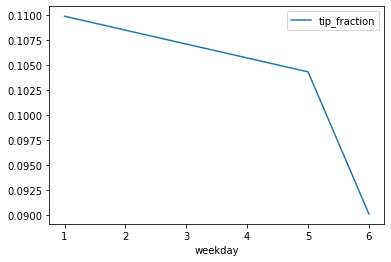

In [131]:
df_plot.compute().plot()

## 7. Plot the average of the new column tip_fraction grouped by hour of day

In [132]:
df_plot = df[["tpep_pickup_datetime","tip_fraction"]].rename(columns={"tpep_pickup_datetime":'hour'})
df_plot = df_plot.groupby(df_plot.hour.dt.hour).mean()
df_plot.compute()

,tip_fraction
hour,
1,0.104328
3,0.095802
4,0.085209
5,0.073275
6,0.081524
7,0.086514
8,0.088393
9,0.089206
10,0.092471


<AxesSubplot:xlabel='hour'>

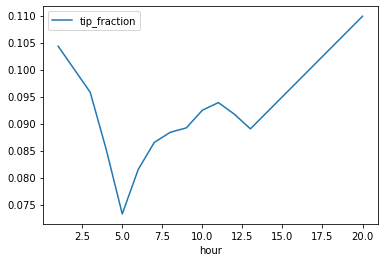

In [133]:
df_plot.compute().plot()

## 8. Observez la variable payment_type,  quelle est son influence sur tip_fraction  ?Pourriez vous expliquer pourquoi ?

In [74]:
df.head()

NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

In [142]:
print(df.groupby(df.payment_type).mean()['tip_fraction'].compute())

payment_type
1    0.151629
2    0.000005
3    0.000000
4    0.000000
Name: tip_fraction, dtype: float64


On observe qu'il n'y a pas de tip pour les paiements de type 3 et 4, et qu'ils sont très faibles pour le type 2. En effet, il est plus simple de donner un pourboire quand on paie en espèce, contrairement au paiement par carte.

## 9. Groupez par nombre de passagers et calculez la moyenne de tip_fraction

In [143]:
df[['passenger_count', 'tip_fraction']].groupby(df.passenger_count).mean().compute()

,passenger_count,tip_fraction
passenger_count,,
0,0.0,0.072372
1,1.0,0.093454
2,2.0,0.090980
3,3.0,0.086477
4,4.0,0.076184
5,5.0,0.092563
6,6.0,0.090833


## 10. Analyse de Fare_amount :

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

SVM = LinearSVR()
parameters = {C:[np.logspace(-3,3,20)]}
clf = GridSearchCV(SVM, parameters)

